In [1]:
# Importação de pacotes básicos necessários para a análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, r2_score, roc_curve, auc, confusion_matrix, precision_recall_curve, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import MRMR
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

In [21]:
#Importação e inspeção dos dados espectrométricos.
#Os dados foram aleatorizados e divididos em 5 folds para validação cruzada esse é o fold 1
df=pd.read_excel('C:/Users/raissa.alves/OneDrive/Mestrado/Artigo 1/cialis.xlsx')
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x653,x654,x655,x656,x657,x658,x659,x660,x661,Y
0,0.052559,0.055038,0.056553,0.056126,0.056977,0.058927,0.060576,0.060587,0.063369,0.068211,...,0.010687,0.009383,0.009468,0.009980,0.011650,0.013632,0.011698,0.010746,0.011595,1
1,0.053486,0.055468,0.056778,0.057013,0.058805,0.061122,0.062941,0.062509,0.064227,0.067844,...,0.009567,0.008001,0.008057,0.008617,0.010323,0.012405,0.010936,0.009874,0.010433,1
2,0.056220,0.055817,0.057222,0.058622,0.059431,0.060673,0.063118,0.064997,0.065842,0.067370,...,0.003204,0.002926,0.002874,0.002943,0.004101,0.005155,0.003752,0.003448,0.003812,1
3,0.059723,0.060030,0.061704,0.064746,0.067571,0.069456,0.070241,0.072759,0.076120,0.079889,...,0.002187,0.001791,0.002183,0.002134,0.002660,0.003023,0.003111,0.002712,0.003215,1
4,0.060660,0.061840,0.062882,0.062642,0.063435,0.065127,0.067960,0.071864,0.075292,0.077792,...,0.006764,0.006505,0.006474,0.006430,0.007305,0.008610,0.008023,0.007417,0.007438,1


In [22]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X = df.iloc[:, :-1]  # Seleciona todas as colunas, exceto a última (variáveis independentes)
y = df.iloc[:, -1].values  # Seleciona a última coluna como um array NumPy (variável dependente)

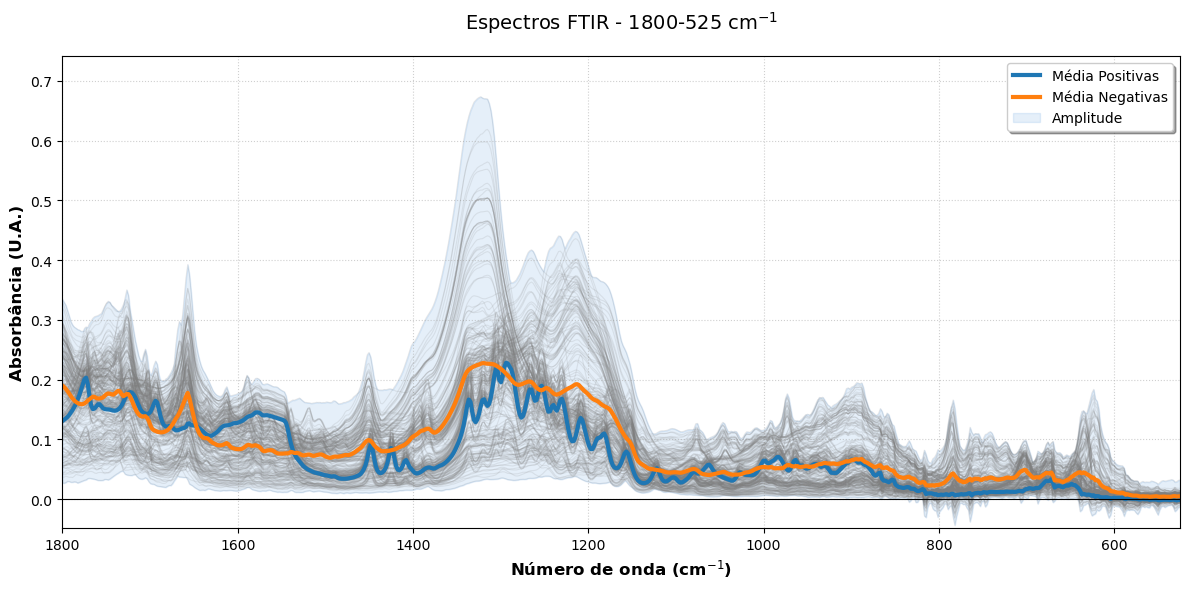

In [23]:
# Visualização dos dados espectrais

wavenumbers =  np.linspace(1800, 525, 661) # Extrai números de onda
spectra = X.values                    # Dados espectrais

# Calcula a média
mean_spectrum = np.mean(spectra, axis=0)

# Configuração do gráfico
plt.figure(figsize=(12, 6))

# Plot de todas as amostras (transparência reduzida)
for i in range(spectra.shape[0]):  # Iterate over the actual number of samples in the spectra array
    plt.plot(wavenumbers, spectra[i, :], 
             color='gray', 
             alpha=0.15,
             linewidth=0.8)
    

# Plot das médias
# Calcular estatísticas por classe
class_0 = X[y == 0]
class_1 = X[y == 1]

mean_0 = class_0.mean(axis=0)  # Média da classe 0
mean_1 = class_1.mean(axis=0)  # Média da classe 1

plt.plot(wavenumbers, mean_1, 
         color='#1f77b4', 
         linewidth=3, 
         label='Média Positivas')

plt.plot(wavenumbers, mean_0, 
         color='#ff7f0e', 
         linewidth=3, 
         label='Média Negativas')

## Destaque da amplitude (mínimo e máximo)
plt.fill_between(wavenumbers, 
                 np.min(spectra, axis=0), 
                 np.max(spectra, axis=0),
                 color='#0066CC',
                 alpha=0.1,
                 label='Amplitude')

# Configuração dos eixos
plt.xlim(1800, 525)  # Eixo invertido para FTIR
plt.ylim(np.min(spectra)*1.1, np.max(spectra)*1.1)

# Elementos gráficos
plt.xlabel('Número de onda (cm$^{-1}$)', fontsize=12, fontweight='bold')
plt.ylabel('Absorbância (U.A.)', fontsize=12, fontweight='bold')
plt.title('Espectros FTIR - 1800-525 cm$^{-1}$', 
          fontsize=14, pad=20)

plt.grid(True, linestyle=':', alpha=0.6)
plt.axhline(y=0, color='black', linewidth=0.8)
plt.legend(frameon=True, shadow=True)

plt.tight_layout()
plt.show()

In [24]:
print("Formato dos dados espectrais:", spectra.shape)
print("Primeiros números de onda:", wavenumbers[:5])
print("Últimos números de onda:", wavenumbers[-5:])

Formato dos dados espectrais: (300, 661)
Primeiros números de onda: [1800.         1798.06818182 1796.13636364 1794.20454545 1792.27272727]
Últimos números de onda: [532.72727273 530.79545455 528.86363636 526.93181818 525.        ]


Text(0.5, 1.0, 'Distribuição de y')

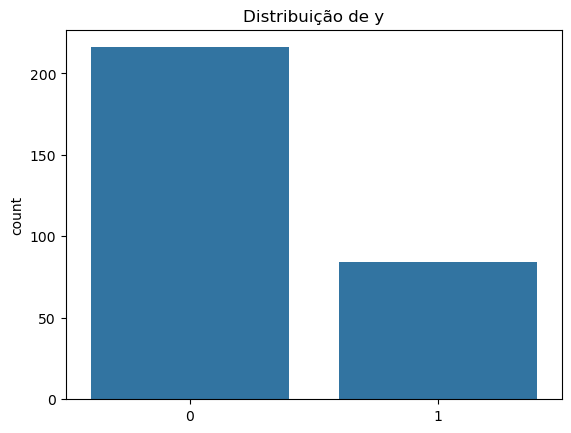

In [25]:
sns.countplot(x=y) if len(np.unique(y)) < 10 else sns.histplot(y)
plt.title("Distribuição de y")

In [34]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):  # Pass both X and y to split()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
# Dividindo o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

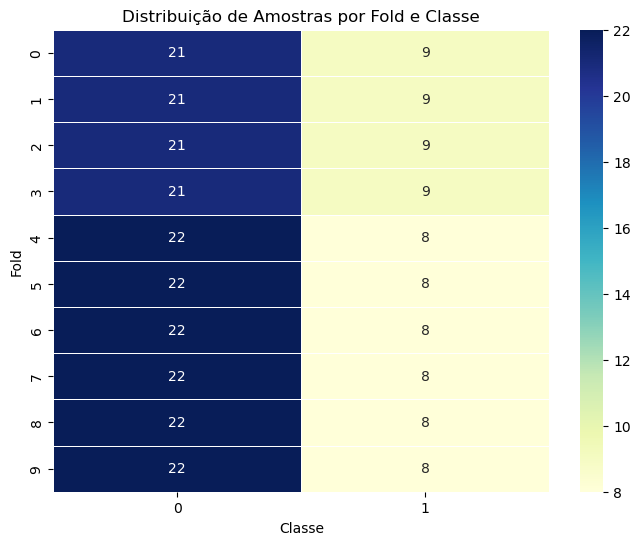

In [35]:
# Criar uma matriz de distribuição de amostras por fold e classe
fold_class_distribution = np.zeros((skf.get_n_splits(), len(np.unique(y))), dtype=int)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
	for class_label in np.unique(y):
		fold_class_distribution[fold_idx, class_label] = np.sum(y[test_idx] == class_label)

# Plotar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(fold_class_distribution, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Distribuição de Amostras por Fold e Classe")
plt.xlabel("Classe")
plt.ylabel("Fold")
plt.show()

In [50]:
#Ranqueamento de variáveis com MRMR

def full_mrmr_ranking(X_train, y_train, n_jobs=-1):
    """
    MRMR otimizado que gera ranking completo com todas as features (661 no seu caso).
    
    Args:
        X_train (pd.DataFrame): DataFrame com todas as 661 features.
        y_train (pd.Series): Classes (0 ou 1).
        n_jobs (int): Número de núcleos para paralelização (-1 = todos).
    
    Returns:
        pd.DataFrame: Ranking completo com todas as 661 features ordenadas por MRMR_Score.
    """
    features = X_train.columns.tolist()
    K = len(features)  # Garante que todas as features serão avaliadas (661)
    selected = []
    scores = {}
    
    # 1. Pré-calcular matriz de correlação absoluta (otimização crítica)
    print("Pré-calculando matriz de correlação...")
    corr_matrix = X_train.corr().abs().values
    
    # 2. Calcular relevância (mutual information) para todas as features
    print("Calculando relevância...")
    mi = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)
    relevance = {f: mi[i] for i, f in enumerate(features)}
    
    # 3. MRMR iterativo (paralelizado e otimizado)
    print("Processando ranking MRMR completo (661 features)...")
    for _ in tqdm(range(K)):
        remaining = [f for f in features if f not in selected]
        
        # Função para cálculo paralelizado do score MRMR
        def calculate_score(f):
            idx_f = X_train.columns.get_loc(f)
            rel = relevance[f]
            
            if selected:
                idx_selected = [X_train.columns.get_loc(s) for s in selected]
                redundancy = np.mean(corr_matrix[idx_f, idx_selected])
            else:
                redundancy = 0
            
            return rel - redundancy
        
        # Paralelização do cálculo (principal ganho de performance)
        feature_scores = Parallel(n_jobs=n_jobs)(
            delayed(calculate_score)(f) for f in remaining
        )
        
        # Encontrar a melhor feature nesta iteração
        best_idx = np.argmax(feature_scores)
        best_feature = remaining[best_idx]
        best_score = feature_scores[best_idx]
        
        scores[best_feature] = best_score
        selected.append(best_feature)
    
    # 4. Gerar DataFrame ordenado com todas as 661 features
    results = pd.DataFrame({
        'Feature': selected,
        'MRMR_Score': [scores[f] for f in selected],
        'Relevance': [relevance[f] for f in selected]
    })
    
    return results

# Uso:
ranked_features= full_mrmr_ranking(X_train, y_train)

# Para salvar como Excel (requer openpyxl ou xlsxwriter)
ranked_features.to_excel(r'C:/Users/raissa.alves/OneDrive/Mestrado/Artigo 1/mrmr_resultscialis.xlsx', index=False)


Pré-calculando matriz de correlação...
Calculando relevância...
Processando ranking MRMR completo (661 features)...


100%|██████████| 661/661 [05:48<00:00,  1.90it/s]


In [51]:
# Visualizar ranking
print("\nTop 661 Comprimentos de Onda:")
print(ranked_features.head(661).to_string(index=False))


Top 661 Comprimentos de Onda:
Feature  MRMR_Score  Relevance
   x568    0.410434   0.410434
    x57    0.270680   0.293973
   x615    0.051515   0.251991
   x463    0.031253   0.222240
   x569    0.022836   0.385888
   x130    0.006197   0.355166
   x220   -0.021320   0.358349
   x526   -0.034611   0.294016
   x129   -0.024418   0.352882
   x327   -0.025957   0.355348
   x654   -0.068328   0.192520
   x221   -0.054669   0.340898
   x131   -0.047493   0.334725
   x605   -0.034459   0.297306
   x295   -0.048418   0.280249
   x119   -0.059271   0.335947
   x607   -0.042891   0.285404
   x570   -0.055640   0.352843
   x132   -0.059004   0.324668
   x230   -0.051779   0.301059
   x603   -0.056526   0.299840
   x128   -0.068289   0.332763
   x326   -0.061834   0.339893
   x229   -0.070687   0.293933
   x606   -0.064576   0.286675
   x127   -0.059680   0.331182
   x296   -0.067964   0.257495
   x613   -0.069252   0.219831
   x235   -0.063328   0.314486
   x120   -0.070728   0.315664
   x604 

Text(0, 0.5, 'Score MRMR')

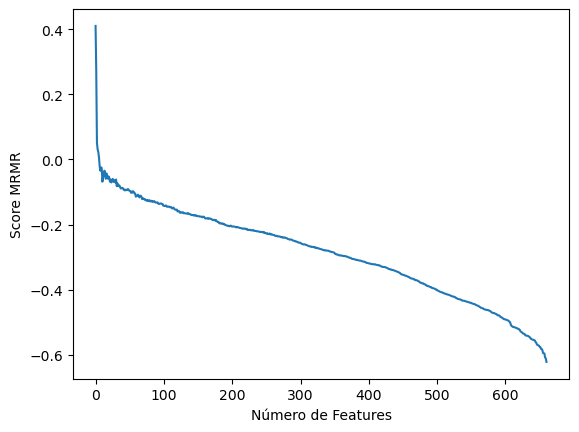

In [52]:
# Analisar curva de decaimento do score
plt.plot(ranked_features['MRMR_Score'])
plt.xlabel('Número de Features')
plt.ylabel('Score MRMR')


Avaliando XGBoost

Fold 1/10:
Features:   1 | Val Acc: 0.9545
Features:   2 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 2 features. Parando avaliação para este fold.

Fold 2/10:
Features:   1 | Val Acc: 0.8636
Features:   2 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 2 features. Parando avaliação para este fold.

Fold 3/10:
Features:   1 | Val Acc: 0.9545
Features:   2 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 2 features. Parando avaliação para este fold.

Fold 4/10:
Features:   1 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 1 features. Parando avaliação para este fold.

Fold 5/10:
Features:   1 | Val Acc: 0.8636
Features:   2 | Val Acc: 0.9545
Features:   3 | Val Acc: 1.0000
--> Acurácia perfeita (1.0) alcançada com 3 features. Parando avaliação para este fold.

Fold 6/10:
Features:   1 | Val Acc: 0.7273
Features:   2 | Val Acc: 0.8182
Features:   3 | Val Acc: 0.8182
Features:   4 | Val Acc: 0.8182
Features:   5 | Val A

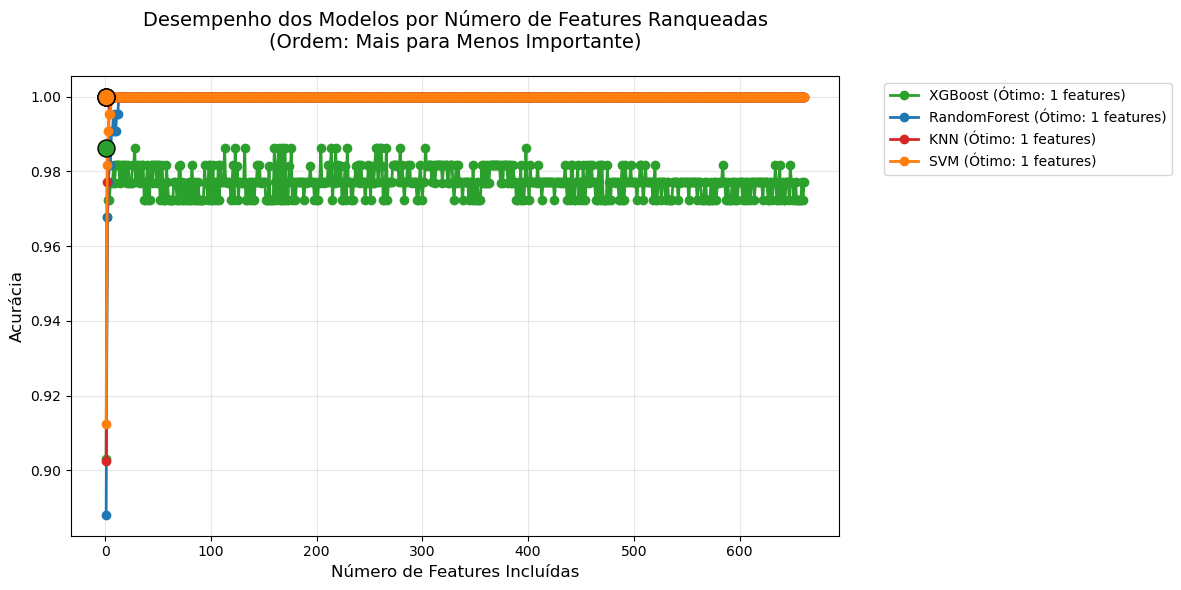

<Figure size 1200x600 with 0 Axes>

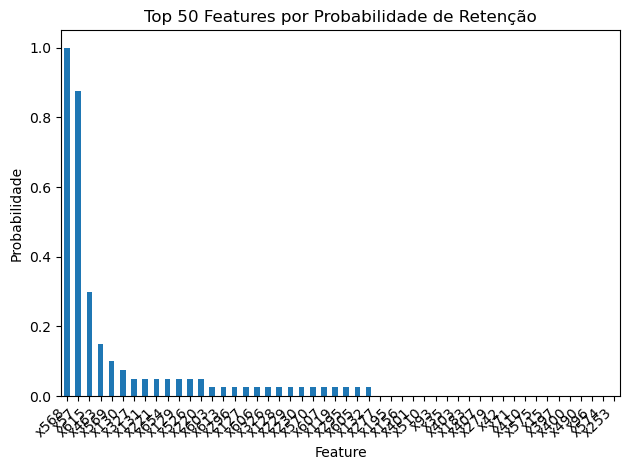

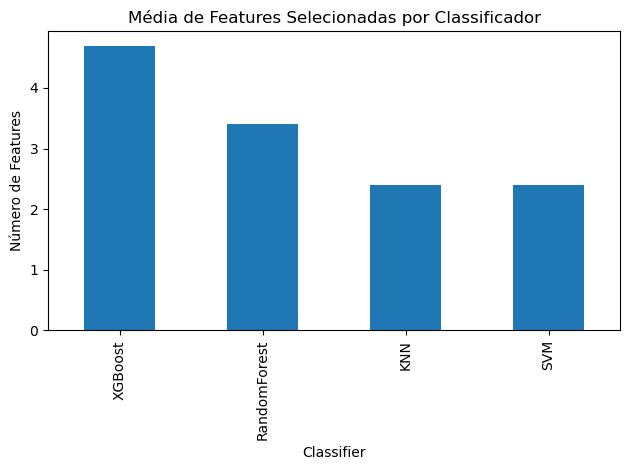


Resultados Consolidados (10-folds):
      Modelo                                                                                   Melhores Parâmetros  Acurácia Média  Acurácia Std  Nº Features Médio  Nº Features Std  Folds com Acurácia 1.0  Folds com Parada Antecipada
RandomForest                                       {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}        1.000000      0.000000                  3         3.382307                      10                           10
         KNN                                      {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}        1.000000      0.000000                  2         0.916515                      10                           10
         SVM                                                                            {'C': 10, 'kernel': 'rbf'}        1.000000      0.000000                  2         1.280625                      10                           10
     XGBoost {'colsample_by

In [53]:
def plot_ranked_features_performance(performance_data: dict[str, dict[str, list[float] | list[int] | int | str]]):
    """
    Gera gráfico comparativo de desempenho por número de features ranqueadas
    """
    plt.figure(figsize=(12, 6))
    colors = {        
        'XGBoost': '#2ca02c',
        'RandomForest': '#1f77b4',
        'SVM': '#ff7f0e',
        'KNN': '#d62728'
    }
    
    for model_name, data in performance_data.items():
        plt.plot(data['feature_counts'], data['accuracies'],
                'o-', color=data['color'],
                markersize=6, linewidth=2,
                label=f"{model_name} (Ótimo: {data['best_num_features']} features)")
        plt.scatter(data['best_num_features'], np.max(data['accuracies']),
                   s=150, color=data['color'], edgecolor='black', zorder=5)
    
    plt.title('Desempenho dos Modelos por Número de Features Ranqueadas\n(Ordem: Mais para Menos Importante)',
             fontsize=14, pad=20)
    plt.xlabel('Número de Features Incluídas', fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 1. Configuração inicial
# Supondo que ranked_features já está definido como um DataFrame com coluna 'Feature'
ranked_features = ranked_features['Feature'].tolist()  # Converte para lista

# 2. Configuração dos modelos com parâmetros para GridSearch
classifiers = {
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'color': '#2ca02c'
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        'color': '#1f77b4'
    },
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance', 'kernel'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        },
        'color': '#d62728'
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly']
        },
        'color': '#ff7f0e'
    }
}

# 3. Estruturas para armazenamento de resultados
feature_retention = defaultdict(list)
classifier_stats = []
selected_features_per_fold = {clf_name: [] for clf_name in classifiers.keys()}
performance_data = {clf_name: {
    'accuracies': [],
    'feature_counts': [],
    'best_num_features': 0,
    'color': classifiers[clf_name]['color']
} for clf_name in classifiers.keys()}
final_results = []

# Configuração do KFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 4. Avaliação progressiva com KFold e critério de parada por acurácia = 1.0
for clf_name, clf_config in classifiers.items():
    print(f'\n{"="*50}\nAvaliando {clf_name}\n{"="*50}')
    
    evaluation_points = list(np.linspace(1, len(ranked_features), 661, dtype=int))
    evaluation_points = sorted(list(set(evaluation_points + [len(ranked_features)])))
    
    fold_results = []
    all_accuracies = np.zeros((10, len(evaluation_points)))  # Matriz para armazenar todos os resultados
   
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f'\nFold {fold}/10:')
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        best_fold_acc = 0
        best_fold_params = None
        best_fold_features = None
        early_stop = False
        
        for i, n in enumerate(evaluation_points):
            if early_stop:
                break
                
            current_features = ranked_features[:n]
            
            try:
                grid = GridSearchCV(
                    estimator=clone(clf_config['model']),
                    param_grid=clf_config['params'],
                    cv=10,
                    scoring='accuracy',
                    n_jobs=-1
                )
                grid.fit(X_fold_train[current_features], y_fold_train)
                
                val_acc = grid.best_estimator_.score(X_fold_val[current_features], y_fold_val)
                all_accuracies[fold-1, i] = val_acc
                
                if val_acc > best_fold_acc:
                    best_fold_acc = val_acc
                    best_fold_params = grid.best_params_
                    best_fold_features = current_features
                
                print(f'Features: {n:3d} | Val Acc: {val_acc:.4f}')
                
                # Critério de parada por acurácia = 1.0
                if val_acc == 1.0:
                    print(f"--> Acurácia perfeita (1.0) alcançada com {n} features. Parando avaliação para este fold.")
                    early_stop = True
                    # Preenche os pontos restantes com 1.0
                    all_accuracies[fold-1, i+1:] = 1.0
                    
            except Exception as e:
                print(f"Erro no {clf_name}, fold {fold}, features {n}: {str(e)}")
                all_accuracies[fold-1, i] = np.nan
                continue
        
        selected_features_per_fold[clf_name].append(best_fold_features)
        
        fold_results.append({
            'fold': fold,
            'best_acc': best_fold_acc,
            'best_n_features': len(best_fold_features) if best_fold_features else 0,
            'params': best_fold_params,
            'stopped_early': early_stop
        })
    
    # Calcular médias para plotagem (ignorando NaNs)
    mean_accuracies = np.nanmean(all_accuracies, axis=0)
    performance_data[clf_name]['accuracies'] = mean_accuracies
    performance_data[clf_name]['feature_counts'] = evaluation_points
    performance_data[clf_name]['best_num_features'] = int(np.min([f['best_n_features'] for f in fold_results]))
    
    # Calcular probabilidade de retenção por feature
    for feature in ranked_features:
        retention_count = sum(1 for fold_features in selected_features_per_fold[clf_name] 
                            if fold_features and feature in fold_features)
        feature_retention[feature].append(retention_count / 10)
    
    # Consolidar resultados entre folds
    avg_acc = np.mean([f['best_acc'] for f in fold_results])
    avg_features = int(np.mean([f['best_n_features'] for f in fold_results]))
    std_acc = np.std([f['best_acc'] for f in fold_results])
    std_features = np.std([f['best_n_features'] for f in fold_results])
    early_stops = sum(1 for f in fold_results if f['stopped_early'])
    
    # Resultados finais
    final_results.append({
        'Modelo': clf_name,
        'Melhores Parâmetros': best_fold_params,
        'Acurácia Média': avg_acc,
        'Acurácia Std': std_acc,
        'Nº Features Médio': avg_features,
        'Nº Features Std': std_features,
        'Folds com Acurácia 1.0': sum(1 for f in fold_results if f['best_acc'] == 1.0),
        'Folds com Parada Antecipada': early_stops
    })

# 5. Processamento dos resultados
retention_df = pd.DataFrame({
    'Feature': feature_retention.keys(),
    'Retention_Probability': [np.mean(probs) for probs in feature_retention.values()]
}).sort_values('Retention_Probability', ascending=False)

for clf_name in classifiers.keys():
    avg_features = np.mean([len(f) if f else 0 for f in selected_features_per_fold[clf_name]])
    classifier_stats.append({
        'Classifier': clf_name,
        'Avg_Features_Selected': avg_features,
        'Top_5_Features': ', '.join(retention_df.head(5)['Feature'].tolist())
    })

feature_selection_details = {}
for clf_name in classifiers.keys():
    all_features = [f for fold_features in selected_features_per_fold[clf_name] 
                   if fold_features for f in fold_features]
    if not all_features:
        feature_counts = pd.DataFrame({'Feature': [], 'Selection_Count': [], 'Selection_Rate': []})
    else:
        feature_counts = pd.Series(all_features).value_counts().reset_index()
        feature_counts.columns = ['Feature', 'Selection_Count']
        feature_counts['Selection_Rate'] = feature_counts['Selection_Count'] / 10
        feature_counts = feature_counts.sort_values('Selection_Rate', ascending=False)
    feature_selection_details[clf_name] = feature_counts

# 6. Geração de relatórios em Excel
with pd.ExcelWriter('feature_selection_report.xlsx') as writer:
    retention_df.to_excel(writer, sheet_name='Retention_Probability', index=False)
    pd.DataFrame(classifier_stats).to_excel(writer, sheet_name='Classifier_Stats', index=False)
    for clf_name in classifiers.keys():
        feature_selection_details[clf_name].to_excel(
            writer, 
            sheet_name=f'{clf_name[:30]} Features',
            index=False
        )
    pd.DataFrame(final_results).to_excel(writer, sheet_name='Summary_Results', index=False)

# 7. Visualizações
plot_ranked_features_performance(performance_data)

plt.figure(figsize=(12, 6))
# Ensure the Retention_Probability column is numeric
retention_df['Retention_Probability'] = pd.to_numeric(retention_df['Retention_Probability'], errors='coerce')

# Drop rows with NaN values in Retention_Probability to avoid plotting issues
retention_df_cleaned = retention_df.dropna(subset=['Retention_Probability'])

retention_df_cleaned.head(50).plot.bar(x='Feature', y='Retention_Probability', legend=False)
plt.title('Top 50 Features por Probabilidade de Retenção')
plt.ylabel('Probabilidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfico de média de features por classificador
pd.DataFrame(classifier_stats).plot.bar(x='Classifier', y='Avg_Features_Selected', legend=False)
plt.title('Média de Features Selecionadas por Classificador')
plt.ylabel('Número de Features')
plt.tight_layout()
plt.show()

# 8. Resultados finais
results_comparison = pd.DataFrame(final_results)
print('\n' + '='*50)
print('Resultados Consolidados (10-folds):')
print('='*50)
print(results_comparison.sort_values('Acurácia Média', ascending=False).to_string(index=False))


Avaliando RandomForest com 3 melhores features


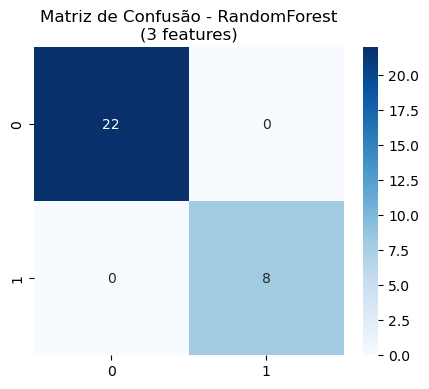


Relatório para RandomForest (top 3 features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Avaliando KNN com 2 melhores features


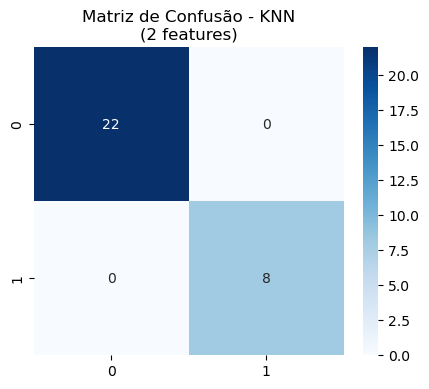


Relatório para KNN (top 2 features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Avaliando SVM com 2 melhores features


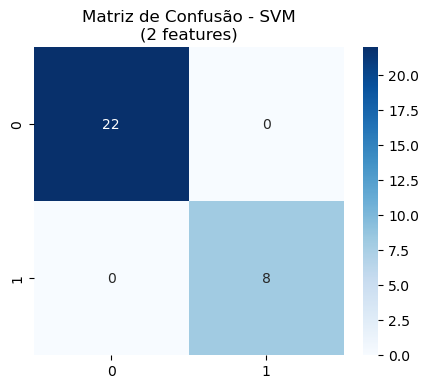


Relatório para SVM (top 2 features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Avaliando XGBoost com 4 melhores features


c:\Users\raissa.alves\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:21:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_delpth" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


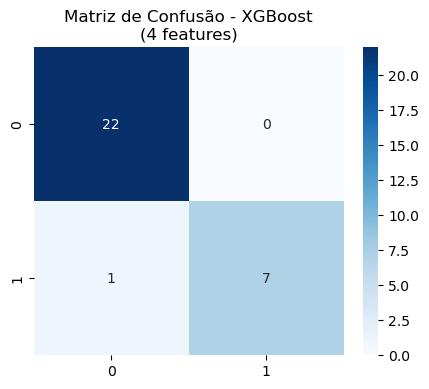


Relatório para XGBoost (top 4 features):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97        30


Resultados Finais com Features Selecionadas:
         Modelo  Nº Features  Acurácia  Precisão  Recall  F1-Score  ROC-AUC
0  RandomForest            3  1.000000       1.0   1.000  1.000000      1.0
1           KNN            2  1.000000       1.0   1.000  1.000000      1.0
2           SVM            2  1.000000       1.0   1.000  1.000000      1.0
3       XGBoost            4  0.966667       1.0   0.875  0.933333      1.0


C:\Users\raissa.alves\AppData\Local\Temp\ipykernel_16484\2771288568.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_comparison, x='Modelo', y='Acurácia', palette='viridis')


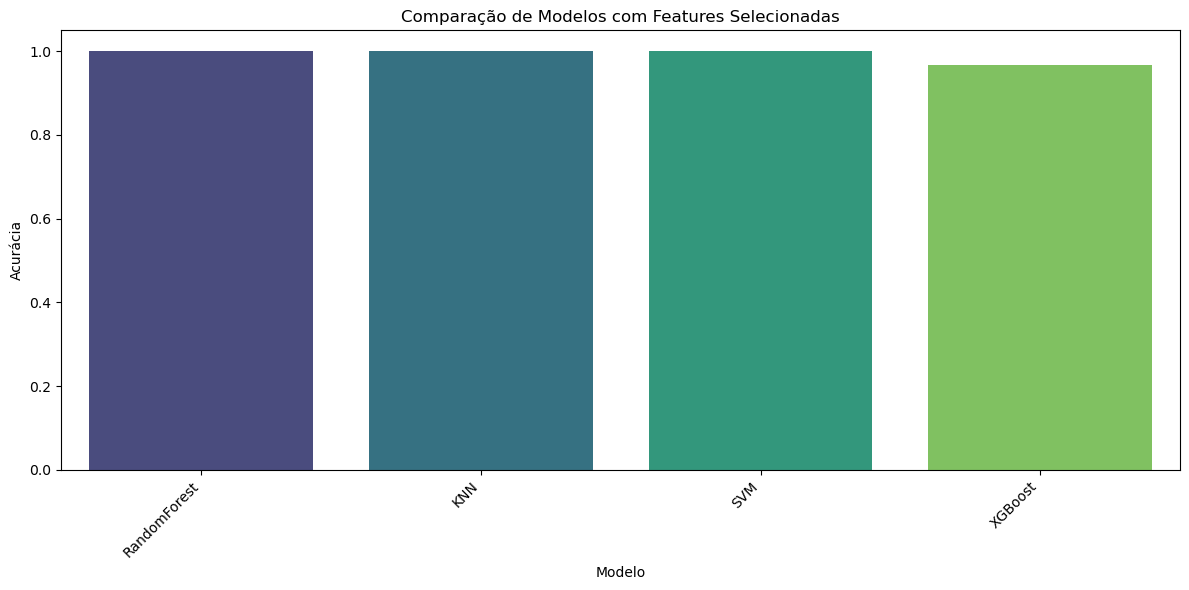

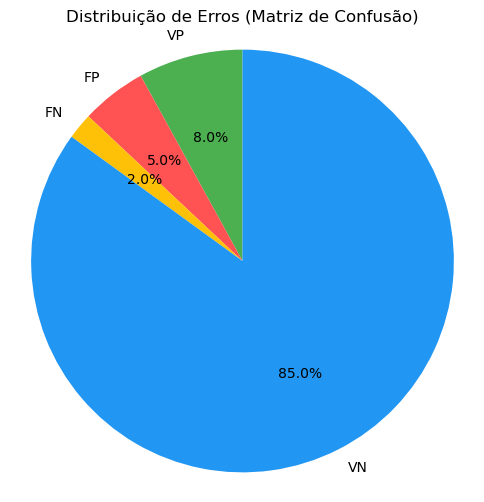

In [ ]:
# Função para avaliação dos modelos com as melhores features
def evaluate_models_with_selected_features(X_train, X_test, y_train, y_test, results_comparison, ranked_features):
    """
    Avalia os modelos usando apenas as melhores features selecionadas
    
    Args:
        X_train, X_test: DataFrames com features
        y_train, y_test: Arrays com labels
        results_df: DataFrame com resultados dos modelos (contém 'Modelo' e 'Nº Features Ótimo')
    """
    
    # Dicionário para armazenar os modelos configurados
    models_config = {     
        
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, max_depth=None, n_estimators=50, min_samples_split=2),
            'num_features': 3
        },        
        'KNN': {
            'model': KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance'),
            'num_features': 2
        },
        'SVM': {
            'model': SVC(random_state=42, C=10, kernel='rbf', probability=True),
            'num_features': 2
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, colsample_bytree=0.8, learning_rate=0.1, max_delpth=3, n_estimators=50, subsample=0.8),
            'num_features': 4
        }
    }
    
    # Extrair as features ranqueadas
    # Remove this line as ranked_features is now passed as an argument
    
    # Avaliação de cada modelo
    final_results = []
    
    for model_name, config in models_config.items():
        print(f"\n{'='*50}\nAvaliando {model_name} com {config['num_features']} melhores features\n{'='*50}")
        
        # Selecionar as melhores features para este modelo
        selected_features = ranked_features[:config['num_features']]
        
        # Verificar se as features existem nos dados
        available_features = [f for f in selected_features if f in X_train.columns]
        if len(available_features) < config['num_features']:
            print(f"Aviso: Apenas {len(available_features)} features disponíveis das {config['num_features']} esperadas")
        
        # Filtrar os dados
        X_train_filtered = X_train[available_features]
        X_test_filtered = X_test[available_features]
        
        # Clonar e treinar o modelo
        model = clone(config['model'])
        model.fit(X_train_filtered, y_train)
        
        # Avaliação
        y_pred = model.predict(X_test_filtered)
        y_proba = model.predict_proba(X_test_filtered)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Métricas
        metrics = {
            'Modelo': model_name,
            'Nº Features': len(available_features),
            'Acurácia': accuracy_score(y_test, y_pred),
            'Precisão': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        }
        final_results.append(metrics)
        
        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão - {model_name}\n({len(available_features)} features)')
        plt.show()
        
        # Relatório de classificação
        print(f"\nRelatório para {model_name} (top {len(available_features)} features):")
        print(classification_report(y_test, y_pred))
    
    # Resultados comparativos
    results_comparison = pd.DataFrame(final_results)
    print("\n" + "="*50)
    print("Resultados Finais com Features Selecionadas:")
    print("="*50)
    print(results_comparison.sort_values('Acurácia', ascending=False))

    # Gráfico de comparação de desempenho
    plt.figure(figsize=(12,6))
    sns.barplot(data=results_comparison, x='Modelo', y='Acurácia', palette='viridis')
    plt.title('Comparação de Modelos com Features Selecionadas')  
    plt.ylabel('Acurácia')
    plt.xlabel('Modelo')
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()    
    
    # Dados da matriz de confusão
    labels = ['VP', 'FP', 'FN', 'VN']
    sizes = [8, 5, 2, 85]
    colors = ['#4CAF50', '#FF5252', '#FFC107', '#2196F3']
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Distribuição de Erros (Matriz de Confusão)')
    plt.axis('equal')  # Assegura que o gráfico é um círculo
    plt.show() 
    
    return results_comparison

# Executar a avaliação
final_results = evaluate_models_with_selected_features(X_train, X_test, y_train, y_test, results_comparison, ranked_features)

In [59]:
#exportar resultados em planilha
final_results.to_excel(r'C:\Users\raissa.alves\Onedrive\Mestrado\Artigo 1\final_results.xlsx', index=False)

In [84]:
#aplicando validação cruzada estratificada nos melhores modelos
def stratified_cross_validation(X, y, ranked_features, shuffle=True, n_splits=10, n_jobs=-1):
    """
    Realiza validação cruzada estratificada e retorna as métricas de desempenho para cada fold. 

    Args:
        X (pd.DataFrame): Dados de entrada (features)
        y (pd.Series): Rótulos (classes)
        ranked_features (list): Lista de features ranqueadas
        shuffle (bool): Se deve embaralhar os dados
        n_splits (int): Número de splits para a validação cruzada
        n_jobs (int): Número de núcleos para paralelização (-1 = todos)

    Returns:
        pd.DataFrame: DataFrame com as métricas de desempenho para cada fold
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    results = []

    # Dicionário para armazenar os modelos configurados
    Modelo = {     
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, max_depth=None, n_estimators=50, min_samples_split=2),
            'num_features': 3
        },        
        'KNN': {
            'model': KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance'),
            'num_features': 2
        },
        'SVM': {
            'model': SVC(random_state=42, C=10, kernel='rbf', probability=True),
            'num_features': 2
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8),
            'num_features': 4
        }
    }
    
    for model_name, config in Modelo.items():
        print(f"\n{'='*50}\nAvaliando {model_name} com {config['num_features']} melhores features\n{'='*50}")
                
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            print(f"Fold {fold}/{skf.n_splits}:")
            X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_test = y[train_idx], y[val_idx]
            
            # Selecionar as melhores features para este modelo
            selected_features = ranked_features[:config['num_features']]
            
            # Filtrar os dados de treino e teste
            X_train_filtered = X_train[selected_features]
            X_test_filtered = X_test[selected_features]
            
            # Clonar e treinar o modelo
            model = clone(config['model'])
            model.fit(X_train_filtered, y_train)
            
            # Avaliação
            y_pred = model.predict(X_test_filtered)
            y_proba = model.predict_proba(X_test_filtered)[:, 1] if hasattr(model, "predict_proba") else None
            
            metrics = {
                'Modelo': model_name,
                'Fold': fold,
                'Acurácia': accuracy_score(y_test, y_pred),
                'Precisão': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'F1': f1_score(y_test, y_pred),
                'ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            }
            results.append(metrics)
            
            print(f"Fold {fold}: Acurácia = {metrics['Acurácia']:.4f}")
            print(f"Fold {fold}: Precisão = {metrics['Precisão']:.4f}")
            print(f"Fold {fold}: Recall = {metrics['Recall']:.4f}")
            print(f"Fold {fold}: F1 = {metrics['F1']:.4f}")
            roc_auc_value = f"{metrics['ROC_AUC']:.4f}" if metrics['ROC_AUC'] is not None else "N/A"
            print(f"Fold {fold}: ROC_AUC = {roc_auc_value}")
    
    results_df = pd.DataFrame(results)
    
    print("="*50)
    print("Resultados Finais:")
    print("="*50)
    print(results_df.to_string(index=False))
    
    return results_df

def calculate_mean_std(results_df):
    """
    Calcula a média e o desvio padrão das métricas de desempenho por Modelo
    
    Args: 
        results_df (pd.DataFrame): DataFrame com os resultados da validação cruzada.

    Returns:
        pd.DataFrame: DataFrame com as médias e desvios padrão das métricas de desempenho por modelo.
    """
    # Agrupa por modelo e calcula média e desvio padrão
    mean_std_df = results_df.groupby('Modelo').agg({
        'Acurácia': ['mean', 'std'],
        'Precisão': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1': ['mean', 'std'],
        'ROC_AUC': ['mean', 'std']
    }).reset_index()
    
    # Renomeia as colunas para melhor legibilidade
    mean_std_df.columns = ['Modelo'] + [
        f'{metric}_{stat}' 
        for metric in ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC'] 
        for stat in ['Média', 'Std']
    ]
    
    return mean_std_df

# Supondo que ranked_features seja uma lista de features ordenadas por importância
# ranked_features = [...]  # Você precisa definir isso antes de chamar a função

# Perform stratified cross-validation
Validação_cruzada_final = stratified_cross_validation(X_train, y_train, ranked_features, shuffle=True, n_splits=10, n_jobs=-1)

# Calcular médias e desvios padrão
mean_results = calculate_mean_std(Validação_cruzada_final)
print("\nResultados Médios e Desvios Padrão por Modelo:")
print(mean_results.to_string(index=False))

# Save the results to an Excel file
Validação_cruzada_final.to_excel(r'C:\Users\raissa.alves\Onedrive\Mestrado\Artigo 1\Notebooks\Validação_cruzada_final.xlsx', index=False)
mean_results.to_excel(r'C:\Users\raissa.alves\Onedrive\Mestrado\Artigo 1\Notebooks\mean_results.xlsx', index=False)


Avaliando RandomForest com 3 melhores features
Fold 1/10:
Fold 1: Acurácia = 0.9630
Fold 1: Precisão = 0.8889
Fold 1: Recall = 1.0000
Fold 1: F1 = 0.9412
Fold 1: ROC_AUC = 1.0000
Fold 2/10:
Fold 2: Acurácia = 1.0000
Fold 2: Precisão = 1.0000
Fold 2: Recall = 1.0000
Fold 2: F1 = 1.0000
Fold 2: ROC_AUC = 1.0000
Fold 3/10:
Fold 3: Acurácia = 1.0000
Fold 3: Precisão = 1.0000
Fold 3: Recall = 1.0000
Fold 3: F1 = 1.0000
Fold 3: ROC_AUC = 1.0000
Fold 4/10:
Fold 4: Acurácia = 1.0000
Fold 4: Precisão = 1.0000
Fold 4: Recall = 1.0000
Fold 4: F1 = 1.0000
Fold 4: ROC_AUC = 1.0000
Fold 5/10:
Fold 5: Acurácia = 0.9630
Fold 5: Precisão = 0.8889
Fold 5: Recall = 1.0000
Fold 5: F1 = 0.9412
Fold 5: ROC_AUC = 1.0000
Fold 6/10:
Fold 6: Acurácia = 0.9630
Fold 6: Precisão = 1.0000
Fold 6: Recall = 0.8571
Fold 6: F1 = 0.9231
Fold 6: ROC_AUC = 1.0000
Fold 7/10:
Fold 7: Acurácia = 0.9630
Fold 7: Precisão = 1.0000
Fold 7: Recall = 0.8571
Fold 7: F1 = 0.9231
Fold 7: ROC_AUC = 1.0000
Fold 8/10:
Fold 8: Acurácia 


Gráficos Individuais por Métrica (barras):


<Figure size 1500x1000 with 0 Axes>

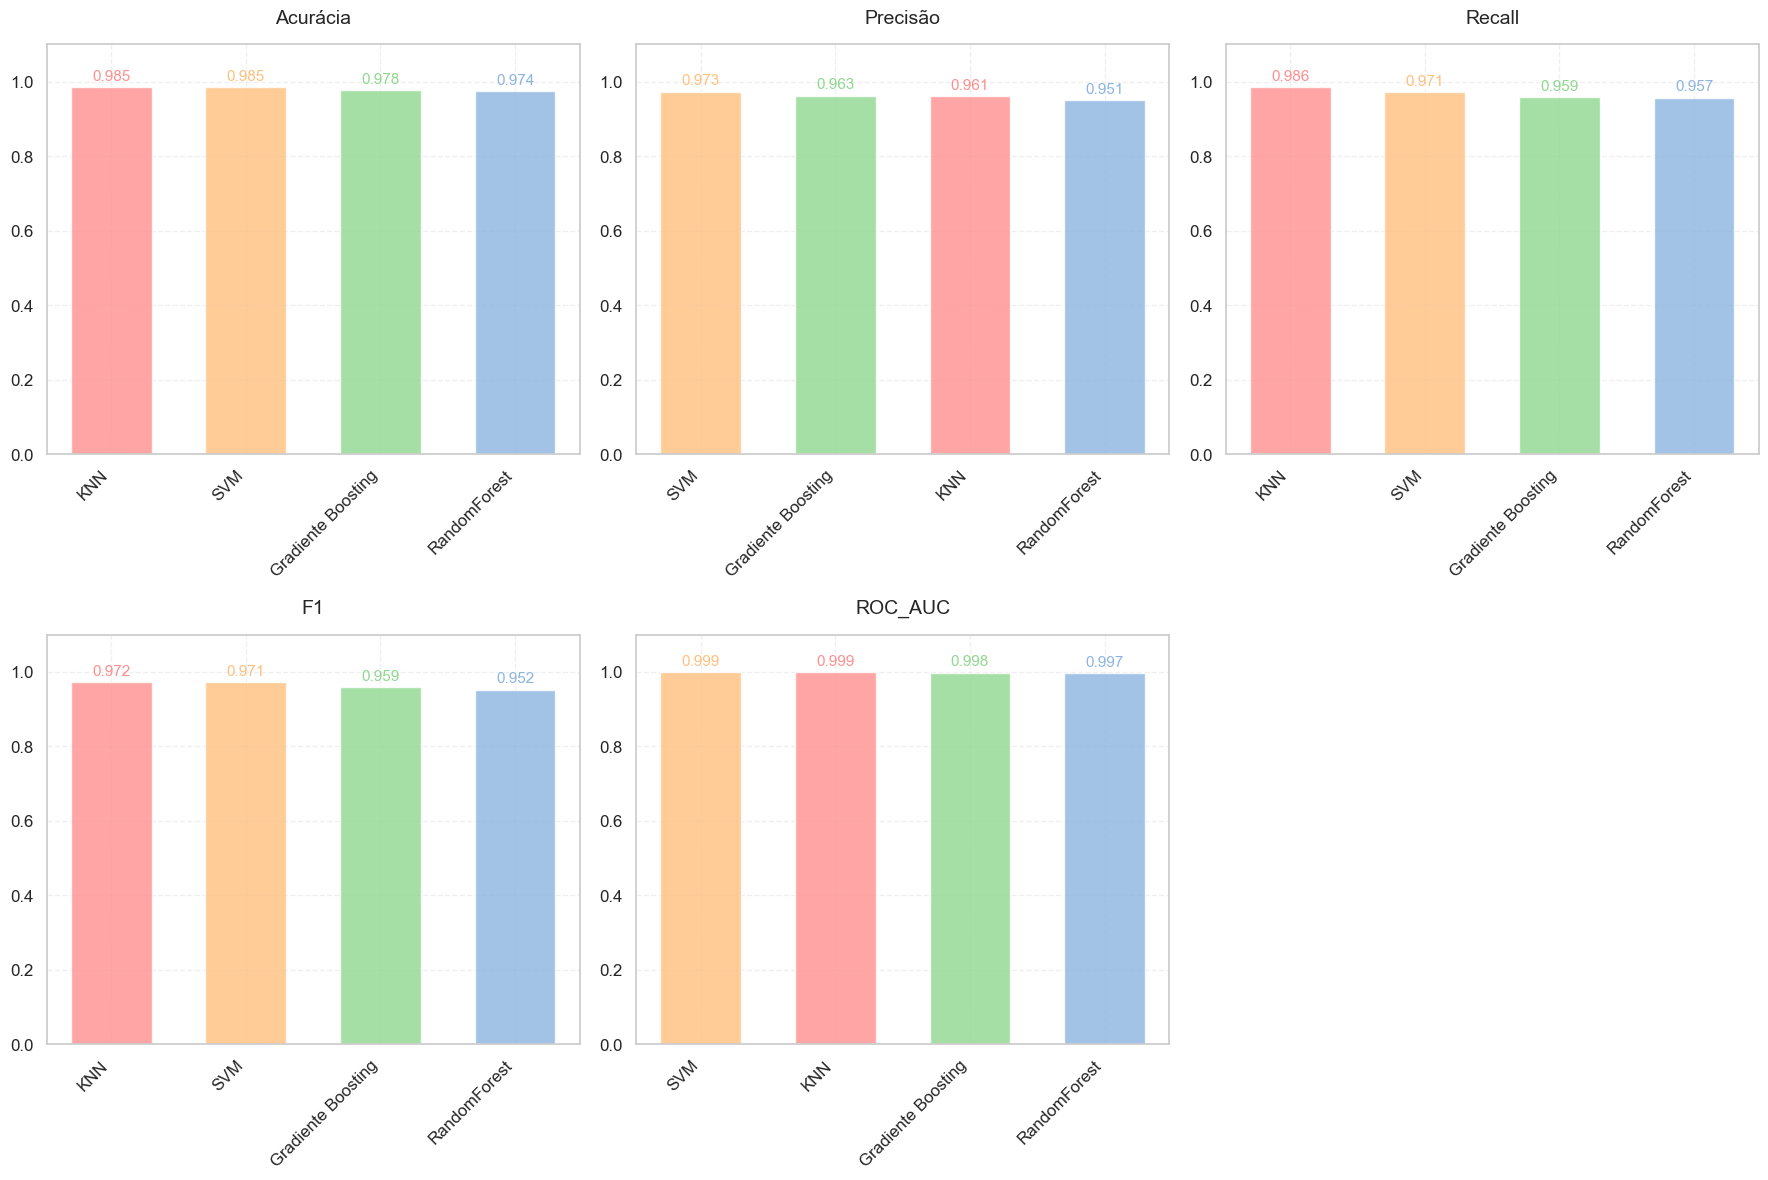


Gráfico Consolidado de Todas as Métricas (barras agrupadas):


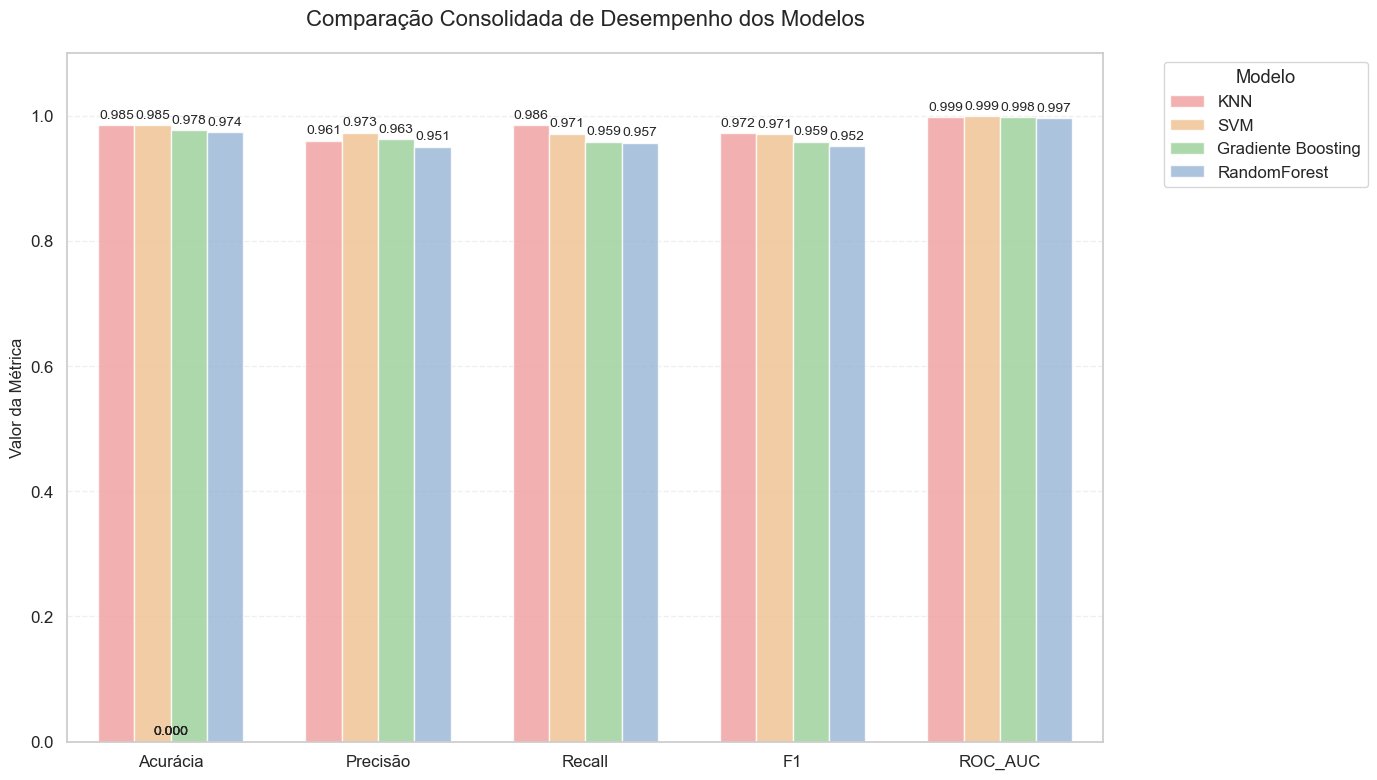

In [88]:
# Configuração de cores personalizadas
colors = {
        'Gradiente Boosting': '#8fd88f',  # Versão mais clara do verde
        'RandomForest': '#8cb4e0',         # Versão mais clara do azul
        'SVM': '#ffc07f',                  # Versão mais clara do laranja
        'KNN': '#ff8f8f'                   # Versão mais clara do vermelho
    }

def plot_model_comparison(mean_results):
    """
    Gera gráficos de barras comparando o desempenho dos modelos sem barras de erro
    
    Args:
        mean_results (pd.DataFrame): DataFrame com as médias das métricas
    """
    # Substituir XGBoost por Gradiente Boosting
    mean_results['Modelo'] = mean_results['Modelo'].replace({'XGBoost': 'Gradiente Boosting'})
    
    # Configurações estéticas
    sns.set(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(15, 10))
    
    # Lista de métricas para plotar
    metrics = ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC']
    
    # Criar subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        # Verificar se a métrica existe nos resultados
        if f'{metric}_Média' not in mean_results.columns:
            continue
            
        # Ordenar modelos pela métrica
        sorted_models = mean_results.sort_values(f'{metric}_Média', ascending=False)
        
        # Plotar barras
        ax = axes[i]
        
        # Criar barras para cada modelo
        for idx, (model, row) in enumerate(sorted_models.iterrows()):
            ax.bar(idx, row[f'{metric}_Média'], 
                  color=colors[row['Modelo']], 
                  alpha=0.8,  # Transparência para suavizar
                  width=0.6)  # Largura da barra
            
            # Adicionar valor no topo da barra
            ax.text(idx, row[f'{metric}_Média'] + 0.01, 
                   f"{row[f'{metric}_Média']:.3f}", 
                   ha='center', va='bottom',
                   color=colors[row['Modelo']], fontsize=11)
        
        ax.set_title(f'{metric}', fontsize=14, pad=15)
        ax.set_xticks(range(len(sorted_models)))
        ax.set_xticklabels(sorted_models['Modelo'], rotation=45, ha='right')
        ax.set_ylim(0, 1.1)
        ax.grid(True, linestyle='--', alpha=0.3)
    
    # Ajustar layout e remover eixos extras
    plt.tight_layout()
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

def plot_consolidated_comparison(mean_results):
    """
    Gera um único gráfico de barras com todas as métricas
    
    Args:
        mean_results (pd.DataFrame): DataFrame com as médias das métricas
    """
    # Substituir XGBoost por Gradiente Boosting
    mean_results['Modelo'] = mean_results['Modelo'].replace({'XGBoost': 'Gradiente Boosting'})
    
    # Preparar dados
    metrics = ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC']
    melted_data = []
    
    for metric in metrics:
        if f'{metric}_Média' in mean_results.columns:
            temp_df = mean_results[['Modelo', f'{metric}_Média']].copy()
            temp_df.columns = ['Modelo', 'Média']
            temp_df['Métrica'] = metric
            melted_data.append(temp_df)
    
    if not melted_data:
        print("Nenhuma métrica válida encontrada para plotar.")
        return
    
    plot_data = pd.concat(melted_data)
    
    # Ordenar as métricas
    metric_order = ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC']
    plot_data['Métrica'] = pd.Categorical(plot_data['Métrica'], categories=metric_order, ordered=True)
    plot_data = plot_data.sort_values(['Métrica', 'Média'], ascending=[True, False])
    
    # Configurar plot
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    # Criar gráfico de barras agrupadas
    ax = sns.barplot(x='Métrica', y='Média', hue='Modelo', 
                    data=plot_data, palette=colors,
                    alpha=0.8, width=0.7)
    
    # Melhorar a visualização
    plt.title('Comparação Consolidada de Desempenho dos Modelos', fontsize=16, pad=20)
    plt.ylabel('Valor da Métrica', fontsize=12)
    plt.xlabel('')
    plt.ylim(0, 1.1)
    
    # Adicionar valores nas barras
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 7), 
                   textcoords='offset points',
                   fontsize=10)
    
    # Configurar legenda
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    
    # Grid mais suave
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(False)
    
    plt.tight_layout()
    plt.show()

# Chamando as funções de plotagem
print("\nGráficos Individuais por Métrica (barras):")
plot_model_comparison(mean_results.copy())

print("\nGráfico Consolidado de Todas as Métricas (barras agrupadas):")
plot_consolidated_comparison(mean_results.copy())

# Opcional: Salvar os gráficos
# plt.savefig('comparacao_modelos_barras.png', dpi=300, bbox_inches='tight')


Gráficos Individuais por Métrica:


<Figure size 1500x1000 with 0 Axes>

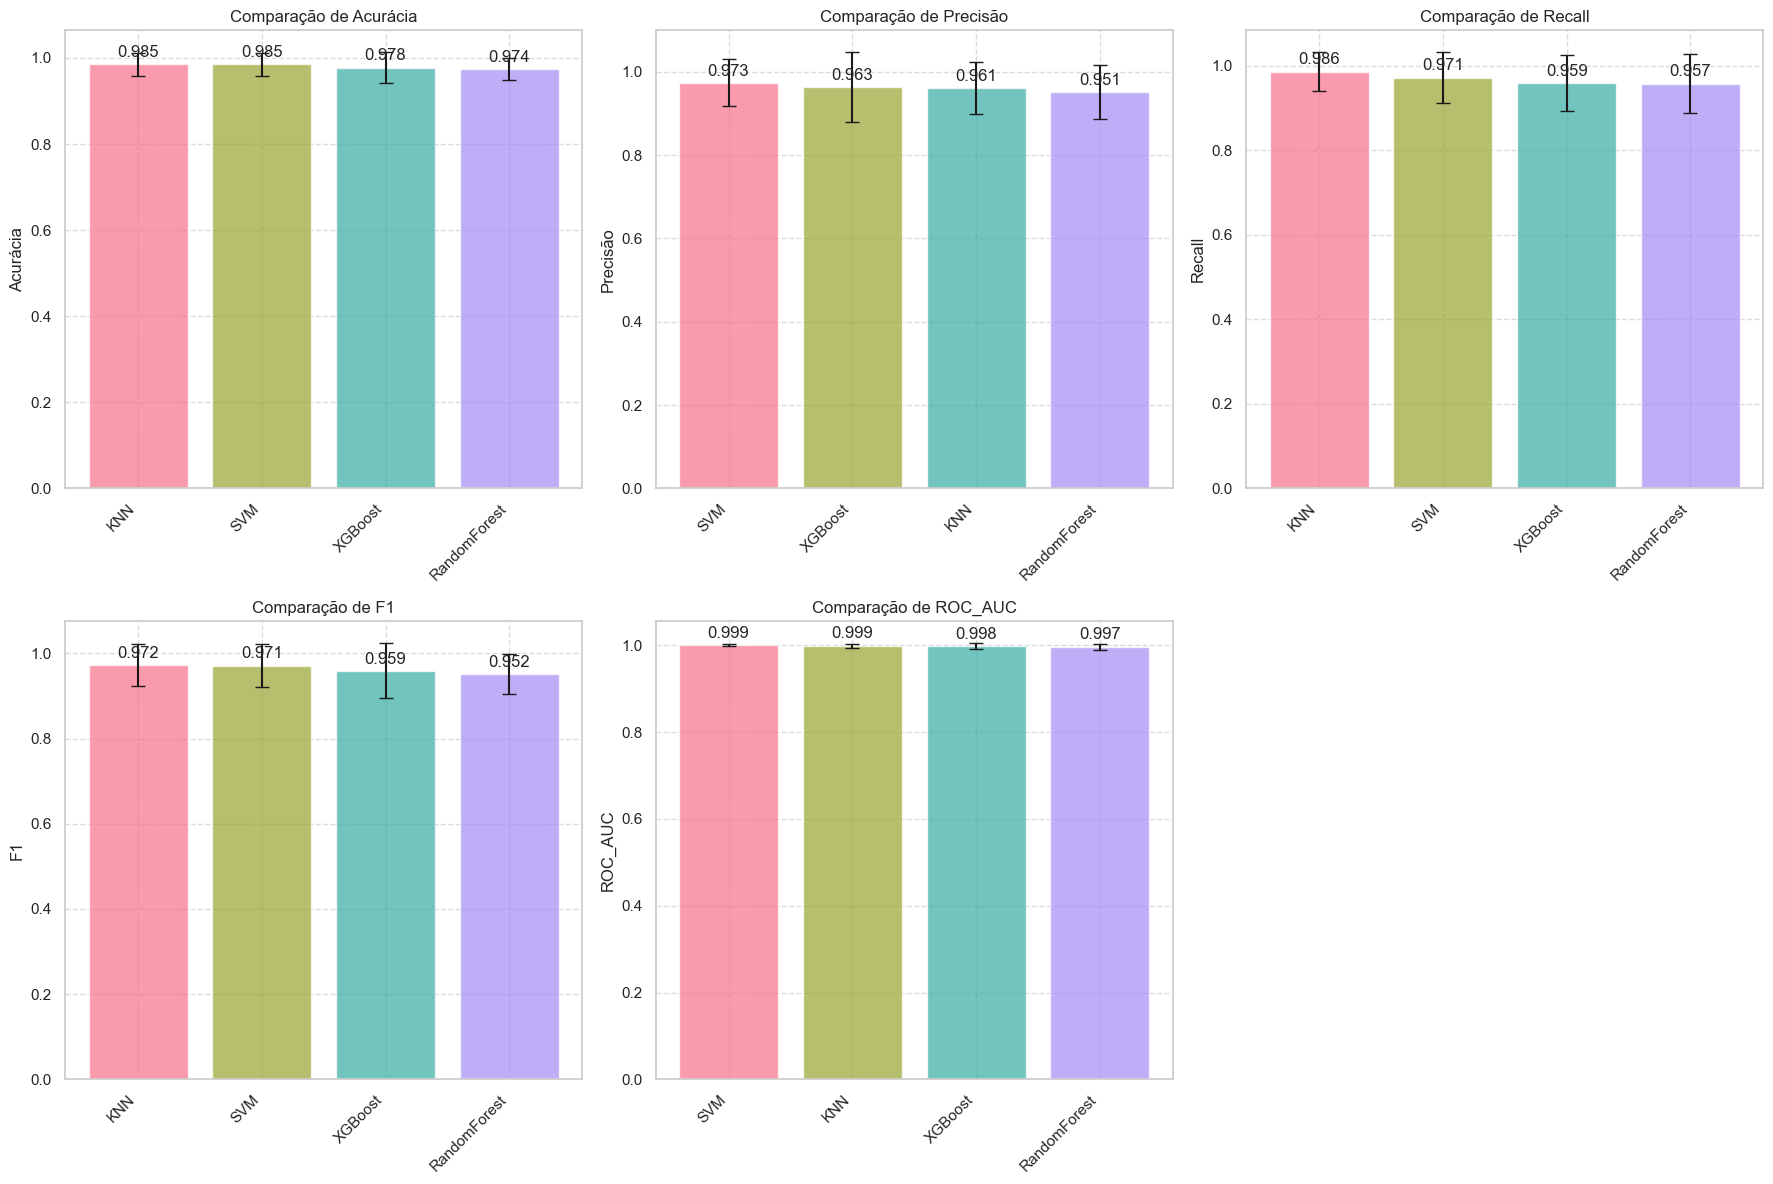


Gráfico Consolidado de Todas as Métricas:


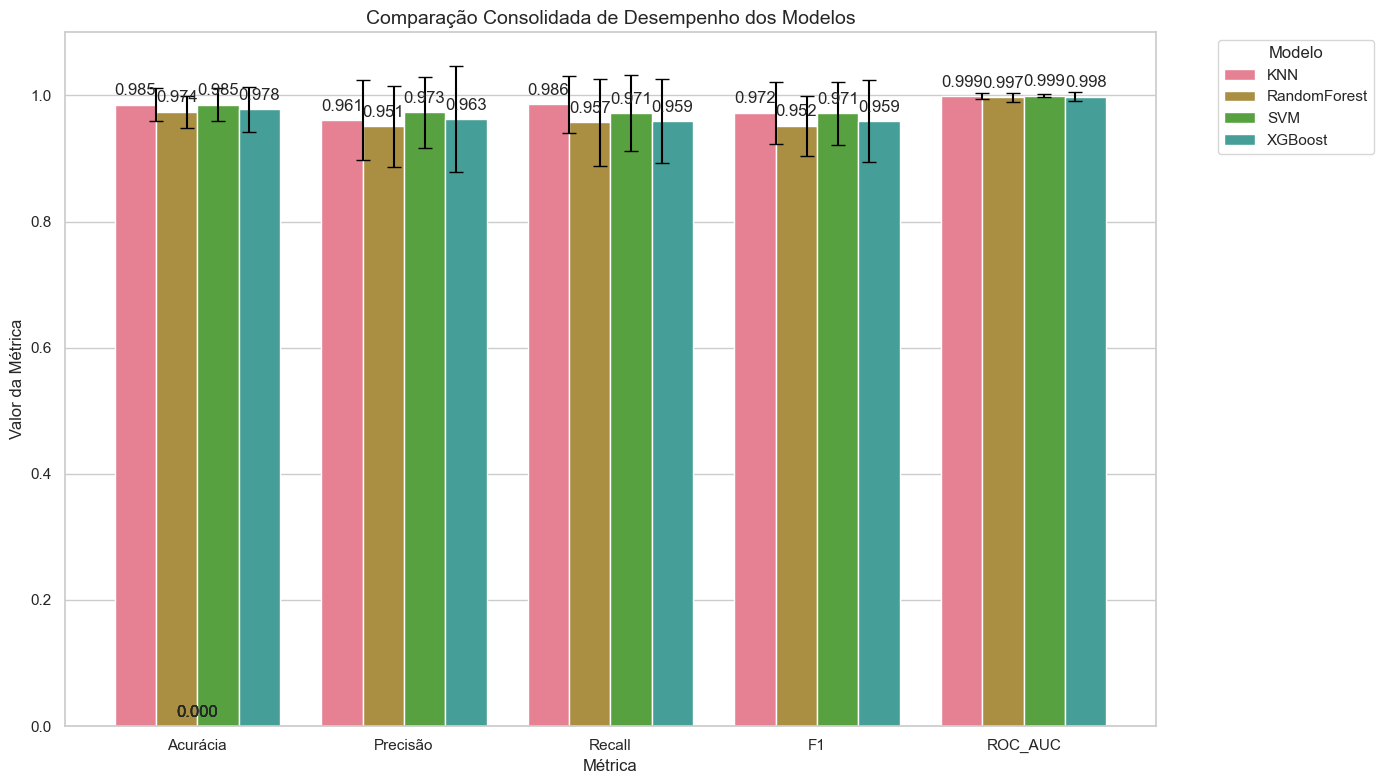

In [85]:
#grafico para comparar desempenho dos modelos
def plot_model_comparison(mean_results):
    """
    Gera gráficos comparando o desempenho dos modelos
    
    Args:
        mean_results (pd.DataFrame): DataFrame com as médias e desvios padrão das métricas
    """
    # Configurações estéticas
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Lista de métricas para plotar
    metrics = ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC']
    
    # Criar subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        # Verificar se a métrica existe nos resultados (ROC_AUC pode estar ausente)
        if f'{metric}_Média' not in mean_results.columns:
            continue
            
        # Ordenar modelos pela métrica (opcional)
        sorted_models = mean_results.sort_values(f'{metric}_Média', ascending=False)
        
        # Plotar barras com erro
        ax = axes[i]
        x = np.arange(len(sorted_models['Modelo']))
        ax.bar(x, sorted_models[f'{metric}_Média'], 
               yerr=sorted_models[f'{metric}_Std'],
               capsize=5, alpha=0.7, color=sns.color_palette("husl", len(x)))
        
        ax.set_title(f'Comparação de {metric}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(sorted_models['Modelo'], rotation=45, ha='right')
        ax.set_ylabel(metric)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Adicionar valores nas barras
        for j, v in enumerate(sorted_models[f'{metric}_Média']):
            ax.text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
    
    # Ajustar layout e remover eixos extras
    plt.tight_layout()
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Gráfico consolidado de todas as métricas
def plot_consolidated_comparison(mean_results):
    """
    Gera um único gráfico com todas as métricas para comparação direta
    
    Args:
        mean_results (pd.DataFrame): DataFrame com as médias e desvios padrão das métricas
    """
    # Preparar dados para seaborn
    metrics = ['Acurácia', 'Precisão', 'Recall', 'F1', 'ROC_AUC']
    melted_data = []
    
    for metric in metrics:
        if f'{metric}_Média' in mean_results.columns:
            temp_df = mean_results[['Modelo', f'{metric}_Média', f'{metric}_Std']].copy()
            temp_df.columns = ['Modelo', 'Média', 'Std']
            temp_df['Métrica'] = metric
            melted_data.append(temp_df)
    
    if not melted_data:
        print("Nenhuma métrica válida encontrada para plotar.")
        return
    
    plot_data = pd.concat(melted_data)
    
    # Configurar plot
    plt.figure(figsize=(14, 8))
    sns.set_palette("husl")
    
    # Criar gráfico de barras
    ax = sns.barplot(x='Métrica', y='Média', hue='Modelo', data=plot_data)
    
    # Adicionar barras de erro manualmente
    for i, model in enumerate(plot_data['Modelo'].unique()):
        for j, metric in enumerate(metrics):
            if metric in plot_data['Métrica'].unique():
                subset = plot_data[(plot_data['Modelo'] == model) & (plot_data['Métrica'] == metric)]
                if not subset.empty:
                    std = subset['Std'].values[0]
                    ax.errorbar(j + i*0.15 - 0.2, subset['Média'], yerr=std, 
                              fmt='none', c='black', capsize=5)
    
    # Melhorar a visualização
    plt.title('Comparação Consolidada de Desempenho dos Modelos', fontsize=14)
    plt.ylabel('Valor da Métrica')
    plt.ylim(0, 1.1)
    plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adicionar valores nas barras
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 10), 
                   textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Chamando as funções de plotagem
print("\nGráficos Individuais por Métrica:")
plot_model_comparison(mean_results)

print("\nGráfico Consolidado de Todas as Métricas:")
plot_consolidated_comparison(mean_results)

# Opcional: Salvar os gráficos
# plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')